! /usr/local/anaconda3/envs/numpy_env/bin/python -m pip install little_mallet_wrapper


In [44]:
import tomotopy as tp
import little_mallet_wrapper
import seaborn
import glob
from pathlib import Path
import pandas as pd
import spacy

In [36]:
directory = "../../2_Preprocessing/Corpus_deepseek_cleaned/"

In [38]:
files = glob.glob(f"{directory}/*.txt")

In [40]:
training_data = []
original_texts = []
titles = []

for file in files:
    text = open(file, encoding='utf-8').read()
    processed_text = little_mallet_wrapper.process_string(text, numbers='remove')
    training_data.append(processed_text)
    original_texts.append(text)
    titles.append(Path(file).stem)
print(titles[:10])


['What_is_DeepSeek,_the_Chinese_AI_startup_that_shoo', 'Chinese_AI_disrupter_DeepSeek_claims_top_spot_in_U', 'Which_countries_have_banned_DeepSeek_and_why?', 'Global_AI_rivalry_is_a_dangerous_game', 'DeepSeek_just_blew_up_the_AI_industry’s_narrative_', 'OpenAI_Says_DeepSeek_May_Have_Improperly_Harvested', 'They_Invested_Billions._Then_the_A.I._Script_Got_F', 'AI_giants_Baidu,_OpenAI_offer_their_chatbots_for_f', 'DeepSeek_banned_from_Australian_government_devices', 'DeepSeek_AI_shakes_American_swagger_and_upends_ass']


In [59]:
len(training_data), len(original_texts), len(titles)

(115, 115, 115)

Train Topic Modelling

In [63]:
# --- 1. Define your custom stopwords ---
custom_stopwords = set([
    'deepseek', 'china', 'chinese', 'say', 'also', 'one', 'new', 'would', 'could', 'use','openai',
])

# --- 2. Load SpaCy for lemmatization (optional but recommended) ---
nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    """
    Tokenizes, lowercases, removes stopwords, keeps only alphabetic tokens, and lemmatizes.
    """
    doc = nlp(text.lower())
    return [token.lemma_ for token in doc if token.is_alpha and token.text not in custom_stopwords]

# --- 3. Preprocess all documents ---
cleaned_training_data = [preprocess(text) for text in training_data]

# --- 4. Initialize the LDA model ---
num_topics = 3
num_topic_words = 10
model = tp.LDAModel(k=num_topics)

# --- 5. Add preprocessed documents ---
for doc in cleaned_training_data:
    model.add_doc(doc)

# --- 6. Train the model ---
print("Topic Model Training...\n")
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')

# --- 7. Print topic results ---
print("\nTopic Model Results:\n")
topics = []
topic_individual_words = []

for topic_number in range(num_topics):
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number}✨\n{topic_words}\n")


Topic Model Training...

Iteration: 0	Log-likelihood: -8.428878827629212
Iteration: 10	Log-likelihood: -8.254345527761318
Iteration: 20	Log-likelihood: -8.176690093824314
Iteration: 30	Log-likelihood: -8.149029806052562
Iteration: 40	Log-likelihood: -8.113052660075313
Iteration: 50	Log-likelihood: -8.0935711760627
Iteration: 60	Log-likelihood: -8.083099902330417
Iteration: 70	Log-likelihood: -8.075183298812536
Iteration: 80	Log-likelihood: -8.073190047255192
Iteration: 90	Log-likelihood: -8.076436135532676

Topic Model Results:

✨Topic 0✨
technology market nvidia intelligence trump may stock power take datum

✨Topic 1✨
model company tech make cost year like industry chip firm

✨Topic 2✨
app government chatgpt chatbot question people information include user ban



Topic Model Results:

✨Topic 0✨
technology market nvidia intelligence trump may stock power take datum

✨Topic 1✨
model company tech make cost year like industry chip firm

✨Topic 2✨
app government chatgpt chatbot question people information include user ban

In [91]:
#  Here do manual topic labeling, which is a standard step after running LDA (or any topic model).
# Why we do this
# LDA gives us lists of words per topic, but these lists are not human-friendly.
# A human interprets the top words and assigns a short descriptive label.
#This makes visualizations (like heatmap) much clearer.

manual_labels = [
    "Technology & AI Trends",     # Topic 0
    "Companies & Economy",        # Topic 1
    "Politics & Government"       # Topic 2
]


In [88]:
# Load topic distributions
topic_distributions = [list(doc.get_topic_dist()) for doc in model.docs]

# Make functions for displaying top documents. The get_top_docs() function is taken from Maria Antoniak’s Little Mallet Wrapper

In [68]:
from IPython.display import Markdown, display
import re

def make_md(string):
    display(Markdown(str(string)))

def get_top_docs(docs, topic_distributions, topic_index, n=5):
    
    sorted_data = sorted([(_distribution[topic_index], _document) 
                          for _distribution, _document 
                          in zip(topic_distributions, docs)], reverse=True)
    
    topic_words = topics[topic_index]
    
    make_md(f"### ✨Topic {topic_index}✨\n\n{topic_words}\n\n")
    print("---")
    
    for probability, doc in sorted_data[:n]:
        # Make topic words bolded
        for word in topic_words.split():
            if word in doc.lower():
                doc = re.sub(f"\\b{word}\\b", f"**{word}**", doc, re.IGNORECASE)
        
        make_md(f'✨  \n**Topic Probability**: {probability}  \n**Document**: {doc}\n\n')
    
    return

In [70]:
# display topic titles
get_top_docs(titles, topic_distributions, topic_index=0, n=6)

### ✨Topic 0✨

technology market nvidia intelligence trump may stock power take datum



---


✨  
**Topic Probability**: 0.581615686416626  
**Document**: What_does_DeepSeek_mean_for_AI's_environmental_imp



✨  
**Topic Probability**: 0.5373800992965698  
**Document**: DeepSeek_shows_AI's_centre_of_power_could_shift_aw



✨  
**Topic Probability**: 0.5362743735313416  
**Document**: DeepSeek:_What_lies_under_the_bonnet_of_the_new_AI



✨  
**Topic Probability**: 0.4993668794631958  
**Document**: Nvidia_shares_sink_as_Chinese_AI_app_DeepSeek_spoo



✨  
**Topic Probability**: 0.4962647259235382  
**Document**: Nvidia_beats_Wall_Street_expectations_in_first_ear



✨  
**Topic Probability**: 0.4915439486503601  
**Document**: OpenAI_‘reviewing’_allegations_that_its_AI_models_



In [72]:
get_top_docs(titles, topic_distributions, topic_index=1, n=5)

### ✨Topic 1✨

model company tech make cost year like industry chip firm



---


✨  
**Topic Probability**: 0.6589955687522888  
**Document**: China_Challenges_Silicon_Valley_for_A.I._Dominance



✨  
**Topic Probability**: 0.6090124249458313  
**Document**: Meet_DeepSeek:_the_Chinese_start-up_that_is_changi



✨  
**Topic Probability**: 0.5932581424713135  
**Document**: They_Invested_Billions._Then_the_A.I._Script_Got_F



✨  
**Topic Probability**: 0.5930418968200684  
**Document**: Hong_Kong_stocks_gain_on_valuation_focus_as_DeepSe



✨  
**Topic Probability**: 0.5918098092079163  
**Document**: Chinese_start-up_DeepSeek_launches_AI_model_that_o



In [93]:
# Output CSV File
import pandas as pd

# Create a DataFrame with document titles and topic distributions
topic_results = []
for title, topic_distribution in zip(titles, topic_distributions):
    topic_results.append({'document': title, 'topic_distribution': topic_distribution})

df = pd.DataFrame(topic_results)

# Assign manual labels to columns
# Each column represents the probability of a topic in that document
df[manual_labels] = pd.DataFrame(df['topic_distribution'].tolist(), index=df.index)

# Drop the original 'topic_distribution' column
df = df.drop('topic_distribution', axis='columns')

df

,document,Technology & AI Trends,Companies & Economy,Politics & Government
0,"What_is_DeepSeek,_the_Chinese_AI_startup_that_...",0.327462,0.532967,0.139571
1,Chinese_AI_disrupter_DeepSeek_claims_top_spot_...,0.280447,0.409616,0.309937
2,Which_countries_have_banned_DeepSeek_and_why?,0.194144,0.184401,0.621455
3,Global_AI_rivalry_is_a_dangerous_game,0.338011,0.312194,0.349795
4,DeepSeek_just_blew_up_the_AI_industry’s_narrat...,0.403746,0.515887,0.080368
...,...,...,...,...
110,US_tech_stocks_partly_recover_after_Trump_says...,0.462268,0.331026,0.206705
111,Diving_into_DeepSeek:_inside_the_7_February_Gu...,0.364280,0.258357,0.377364
112,Hong_Kong_stocks_gain_on_valuation_focus_as_De...,0.254844,0.593042,0.152114
113,Nvidia_and_Microsoft_shares_steady_after_DeepS...,0.440057,0.390561,0.169381


In [97]:
# Save to CSV
df.to_csv("../output/topic_results.csv", index=False, encoding="utf-8")


Choose a topic from the results above and write down its corresponding topic number below.

Topic: Technology & AI Trends


In [100]:
df.sort_values(by='Technology & AI Trends', ascending=False)[:6]

,document,Technology & AI Trends,Companies & Economy,Politics & Government
96,What_does_DeepSeek_mean_for_AI's_environmental...,0.581616,0.287704,0.130681
101,DeepSeek_shows_AI's_centre_of_power_could_shif...,0.537380,0.255194,0.207426
47,DeepSeek:_What_lies_under_the_bonnet_of_the_ne...,0.536274,0.301519,0.162206
91,Nvidia_shares_sink_as_Chinese_AI_app_DeepSeek_...,0.499367,0.371355,0.129279
51,Nvidia_beats_Wall_Street_expectations_in_first...,0.496265,0.378723,0.125013
34,OpenAI_‘reviewing’_allegations_that_its_AI_mod...,0.491544,0.220722,0.287734


Explore Heatmap of Topics and Texts
We can visualize and compare these topic probability distributions with a heatmap by using the little_mallet_wrapper.plot_categories_by_topics_heatmap() function.

We need a list of target_labels, the sample of texts that we’d like to visualize and compare with the heatmap. Below we make our list of desired target labels.

In [135]:
target_labels = ["US_tech_stocks_plunge_on_China_AI’s_unexpectedly_s",
                 "Hong_Kong_stocks_gain_on_valuation_focus_as_DeepSe",
                 "A_shocking_Chinese_AI_advancement_called_DeepSeek_",
                 "China’s_DeepSeek_causes_rout_among_AI-linked_stock",
                 "DeepSeek_breakthrough,_Nvidia_stock_rout_raise_con",
                 "My_Take_|_Chinese_start-up_DeepSeek_looks_set_to_r"
]

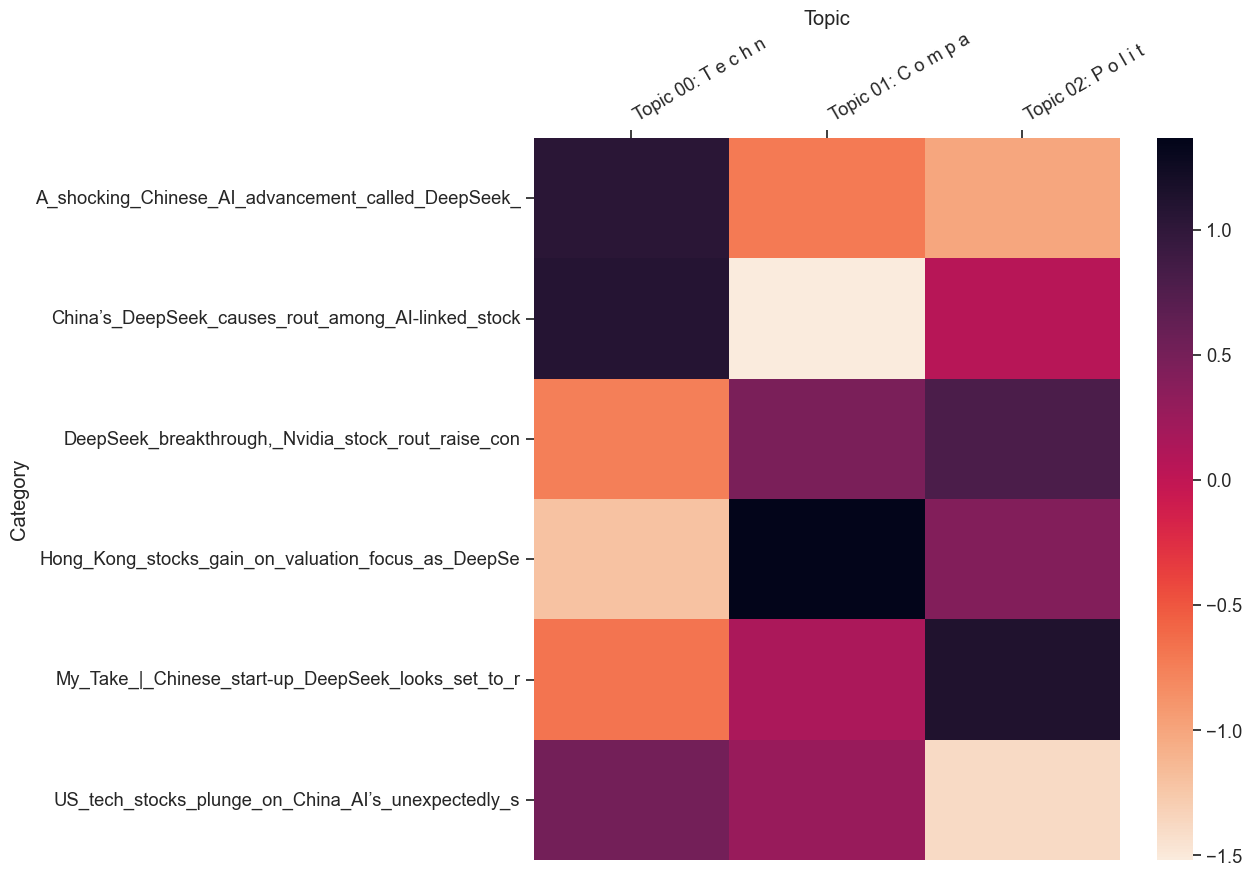

In [137]:
little_mallet_wrapper.plot_categories_by_topics_heatmap(titles,
                                      topic_distributions,
                                      manual_labels,                                   
                                      target_labels=target_labels,
                                      dim= (13, 9)
                                     )

# Save the current figure
plt.savefig("../visualizations/categories_by_topics_heatmap1.pdf", bbox_inches='tight')
plt.close()

In [139]:
# make a random list of target labels
import random
target_labels = random.sample(titles, 10)

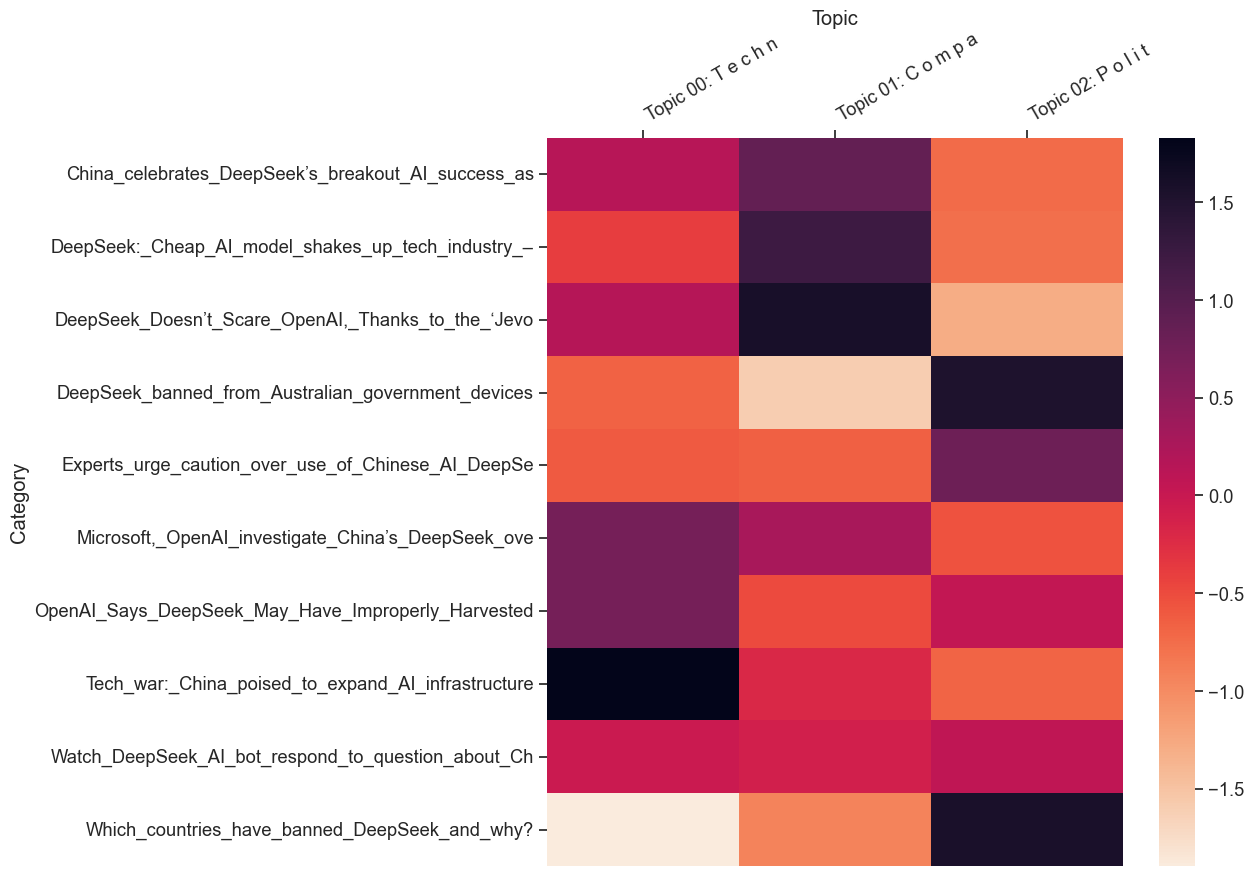

In [141]:
import matplotlib.pyplot as plt

little_mallet_wrapper.plot_categories_by_topics_heatmap(titles,
                                      topic_distributions,
                                      manual_labels, 
                                    
                                      target_labels=target_labels,
                                      dim= (13, 9)
                                     )
# Save the current figure
plt.savefig("../visualizations/categories_by_topics_heatmap2.pdf", bbox_inches='tight')
plt.close()